In [1]:
import os
import pickle
import sys

sys.path.append(os.path.join(".."))

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
from src.model_utils import custom_multiclass_report, CroplandDatasetTest
from sklearn.metrics import classification_report, confusion_matrix
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from catboost import CatBoostClassifier

##  Data

In [2]:
# Read dictionary pkl file
with open(os.path.join("..", "data", "processed_files", "pkls", "X_lstm.pkl"), "rb") as fp:
    X_lstm = pickle.load(fp)

with open(os.path.join("..", "data", "processed_files", "pkls", "X.pkl"), "rb") as fp:
    X = pickle.load(fp)

with open(os.path.join("..", "data", "processed_files", "pkls", "y.pkl"), "rb") as fp:
    y = pickle.load(fp)

with open(os.path.join("..", "data", "npys_data", "X_keys.pkl"), "rb") as fp:
    keys = pickle.load(fp)

In [3]:
X_test = X["Test"]
y_test = np.argmax(y["Test"], 1)

X_test_nn = torch.tensor(X["Test"], dtype=torch.float)
X_monthly_test = torch.tensor(X_lstm["Test"][0], dtype=torch.float)
X_static_test = torch.tensor(X_lstm["Test"][1], dtype=torch.float)

del X, y

## Testing models on the same test data

In [4]:
path_to_pickled_models = os.path.join("..", "results", "pickle_models")

clf_dict = {
    "lr": os.path.join(path_to_pickled_models, "logreg.pkl"),
    "catboost": os.path.join(path_to_pickled_models, "catboost.pkl"),
}

clf_nn_dict = {
    "mlp": os.path.join(path_to_pickled_models, "mlp.pkl"),
    "lstm": os.path.join(path_to_pickled_models, "lstm.pkl"),
    "conv_lstm": os.path.join(path_to_pickled_models, "conv_lstm.pkl"),
    "transformer": os.path.join(path_to_pickled_models, "transformer.pkl"),
}

### Calculate metrics for all models in a sequence

In [5]:
y_probs = dict()
softmax = nn.Softmax(dim=1)
joint_dict = {**clf_dict, **clf_nn_dict}
# create an instance of pl.Trainer
trainer = pl.Trainer(accelerator="gpu", devices=[1])

for model in tqdm(joint_dict):
    if model == "mlp":
        loaded_model = torch.load(joint_dict[model])
        loaded_model.eval()

        # check metrics
        predictions = torch.cat(
            trainer.predict(loaded_model, DataLoader(X_test_nn, batch_size=2048)), dim=0
        )
        softmax = nn.Softmax(dim=1)
        y_prob = softmax(predictions.float()).numpy()
        y_pred = np.argmax(y_prob, 1)
        y_probs[model] = y_prob
    elif model in ["lstm", "conv_lstm", "transformer"]:
        loaded_model = torch.load(clf_nn_dict[model])
        loaded_model.eval()

        # check metrics
        predictions = torch.cat(
            trainer.predict(
                loaded_model,
                DataLoader(
                    CroplandDatasetTest((X_monthly_test, X_static_test)),
                    batch_size=2048,
                ),
            ),
            dim=0,
        )
        softmax = nn.Softmax(dim=1)
        y_prob = softmax(predictions.float()).numpy()
        y_pred = np.argmax(y_prob, 1)
        y_probs[model] = y_prob
        
    elif model == "catboost":
        loaded_model = CatBoostClassifier()
        loaded_model.load_model(clf_dict[model])
        y_prob = loaded_model.predict_proba(X_test)
        y_pred = np.argmax(y_prob, 1)
        y_probs[model] = y_prob
    else:
        # loading the models:
        loaded_model = pickle.load(open(joint_dict[model], "rb"))
        y_pred = loaded_model.predict(X_test)
        y_prob = loaded_model.predict_proba(X_test)
        y_probs[model] = y_prob

    print(model + " results:")
    # custom_multiclass_report(y_test, y_pred, y_probs[model])
    print(classification_report(y_test, y_pred))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
  0%|          | 0/6 [00:00<?, ?it/s]

lr results:


 17%|█▋        | 1/6 [00:05<00:29,  5.83s/it]

              precision    recall  f1-score   support

           0       0.95      0.89      0.92   1548525
           1       0.61      0.24      0.34     19369
           2       0.30      0.19      0.23     77414
           3       0.38      0.75      0.51    154829

    accuracy                           0.84   1800137
   macro avg       0.56      0.52      0.50   1800137
weighted avg       0.87      0.84      0.85   1800137

catboost results:


 33%|███▎      | 2/6 [01:38<03:48, 57.09s/it]

              precision    recall  f1-score   support

           0       0.98      0.93      0.96   1548525
           1       0.78      0.58      0.67     19369
           2       0.60      0.66      0.63     77414
           3       0.58      0.85      0.69    154829

    accuracy                           0.91   1800137
   macro avg       0.74      0.76      0.74   1800137
weighted avg       0.93      0.91      0.92   1800137



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

mlp results:


 50%|█████     | 3/6 [02:07<02:12, 44.01s/it]

              precision    recall  f1-score   support

           0       0.99      0.87      0.92   1548525
           1       0.49      0.71      0.58     19369
           2       0.37      0.72      0.49     77414
           3       0.46      0.80      0.58    154829

    accuracy                           0.85   1800137
   macro avg       0.58      0.77      0.65   1800137
weighted avg       0.91      0.85      0.87   1800137



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

lstm results:


 67%|██████▋   | 4/6 [02:45<01:23, 41.59s/it]

              precision    recall  f1-score   support

           0       0.98      0.85      0.91   1548525
           1       0.43      0.49      0.46     19369
           2       0.31      0.54      0.39     77414
           3       0.41      0.77      0.54    154829

    accuracy                           0.83   1800137
   macro avg       0.53      0.66      0.57   1800137
weighted avg       0.90      0.83      0.85   1800137



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

conv_lstm results:


 83%|████████▎ | 5/6 [03:16<00:38, 38.08s/it]

              precision    recall  f1-score   support

           0       0.98      0.87      0.92   1548525
           1       0.52      0.46      0.49     19369
           2       0.37      0.61      0.46     77414
           3       0.44      0.81      0.57    154829

    accuracy                           0.85   1800137
   macro avg       0.58      0.69      0.61   1800137
weighted avg       0.91      0.85      0.87   1800137



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

transformer results:


100%|██████████| 6/6 [03:56<00:00, 39.42s/it]

              precision    recall  f1-score   support

           0       0.97      0.83      0.90   1548525
           1       0.28      0.44      0.34     19369
           2       0.26      0.38      0.31     77414
           3       0.35      0.75      0.48    154829

    accuracy                           0.80   1800137
   macro avg       0.46      0.60      0.51   1800137
weighted avg       0.88      0.80      0.83   1800137



Mean models results:
              precision    recall  f1-score       support
0              0.981978  0.893071  0.935416  1.548525e+06
1              0.643742  0.499200  0.562331  1.936900e+04
2              0.488603  0.573992  0.527866  7.741400e+04
3              0.458431  0.846372  0.594731  1.548290e+05
accuracy       0.871094  0.871094  0.871094  8.710943e-01
macro avg      0.643188  0.703159  0.655086  1.800137e+06
weighted avg   0.912091  0.871094  0.884573  1.800137e+06


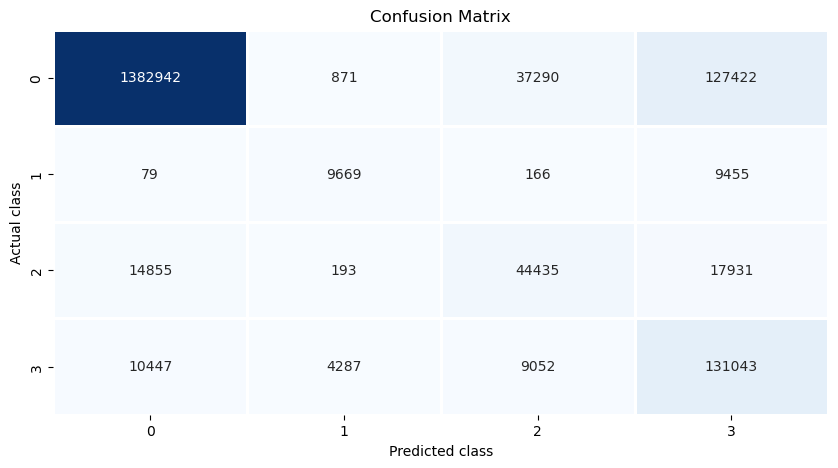

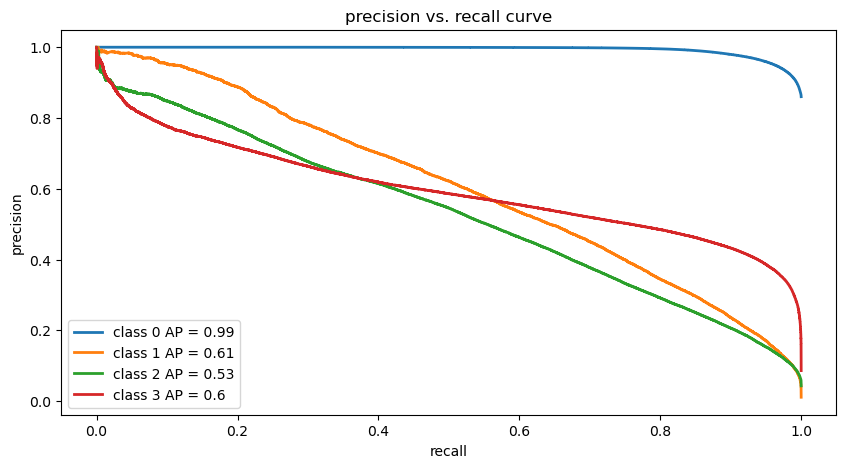

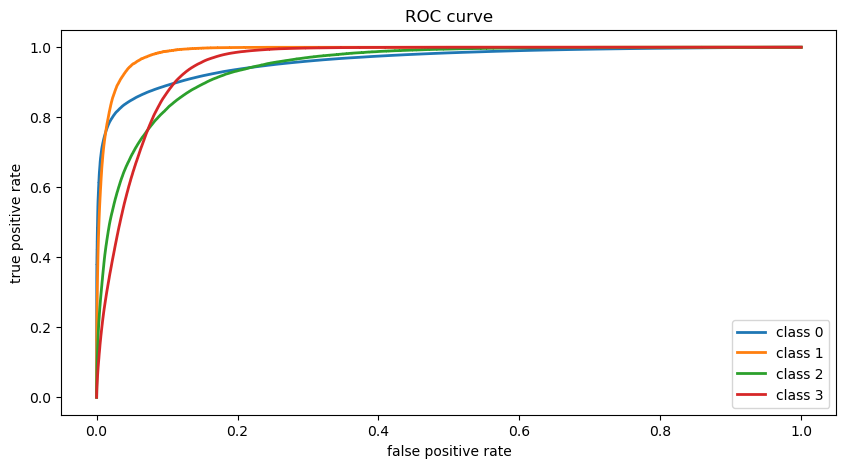

0 ROC AUC OvR: 0.9611
1 ROC AUC OvR: 0.9886
2 ROC AUC OvR: 0.9449
3 ROC AUC OvR: 0.9523
average ROC AUC OvR: 0.9617


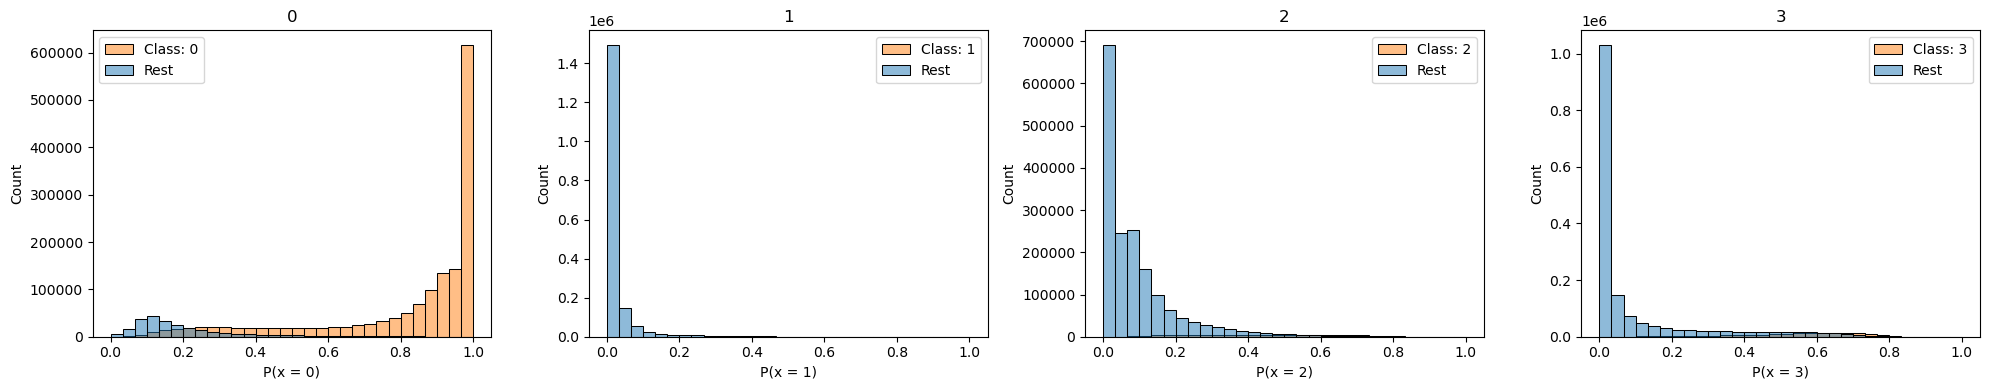

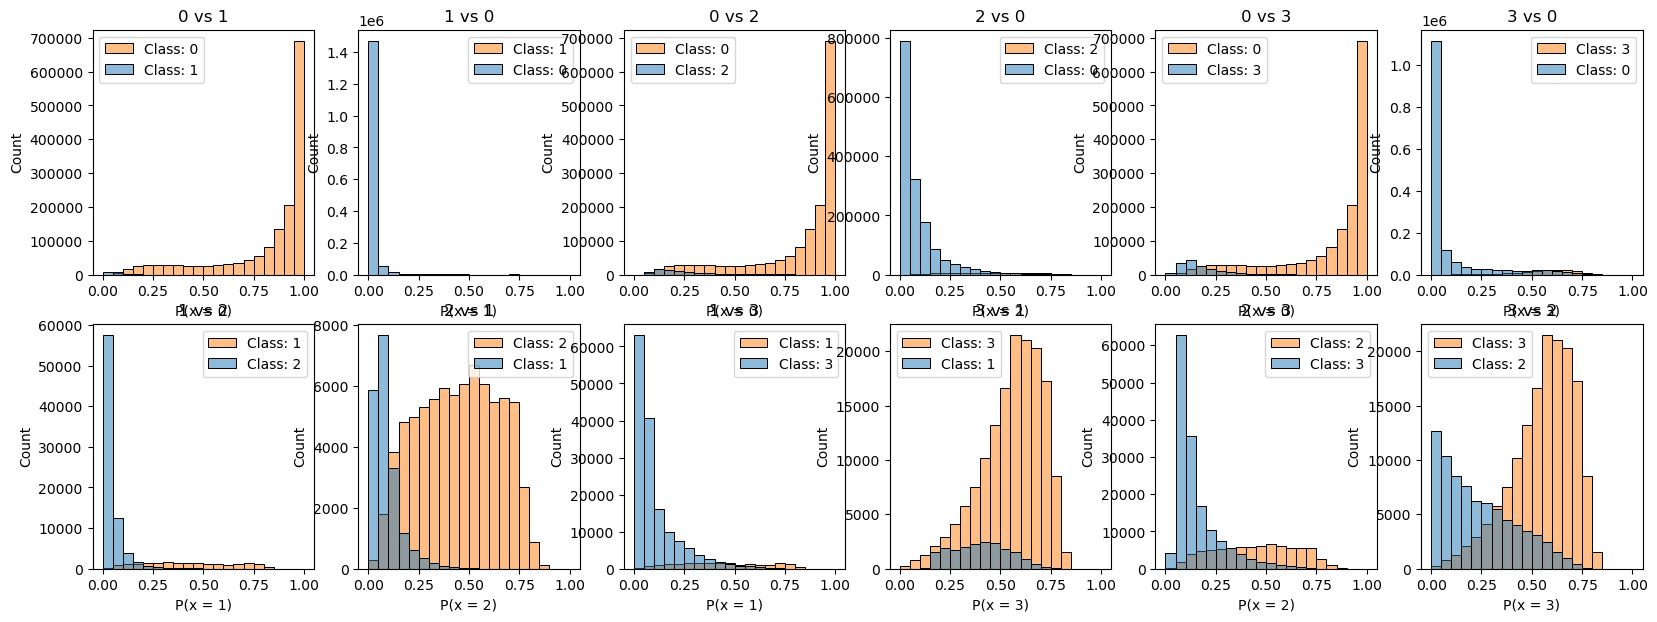

0 vs 1 ROC AUC OvO: 0.9950
1 vs 0 ROC AUC OvO: 0.9961
0 vs 2 ROC AUC OvO: 0.9362
2 vs 0 ROC AUC OvO: 0.9493
0 vs 3 ROC AUC OvO: 0.9693
3 vs 0 ROC AUC OvO: 0.9573
1 vs 2 ROC AUC OvO: 0.9813
2 vs 1 ROC AUC OvO: 0.9638
1 vs 3 ROC AUC OvO: 0.9178
3 vs 1 ROC AUC OvO: 0.7759
2 vs 3 ROC AUC OvO: 0.8990
3 vs 2 ROC AUC OvO: 0.8959
average ROC AUC OvO: 0.9364


In [6]:
# Mean probabilities

mean_y_prob = np.divide(sum(y_probs.values()), len(y_probs.keys()))
mean_y_pred = [np.argmax(i) for i in mean_y_prob]


print("Mean models results:")
custom_multiclass_report(y_test, mean_y_pred, mean_y_prob)

Mean models results:
              precision    recall  f1-score       support
0              0.984285  0.870241  0.923756  1.548525e+06
1              0.523595  0.551655  0.537259  1.936900e+04
2              0.392110  0.601997  0.474896  7.741400e+04
3              0.430185  0.810675  0.562095  1.548290e+05
accuracy       0.850154  0.850154  0.850154  8.501542e-01
macro avg      0.582544  0.708642  0.624501  1.800137e+06
weighted avg   0.906204  0.850154  0.869188  1.800137e+06


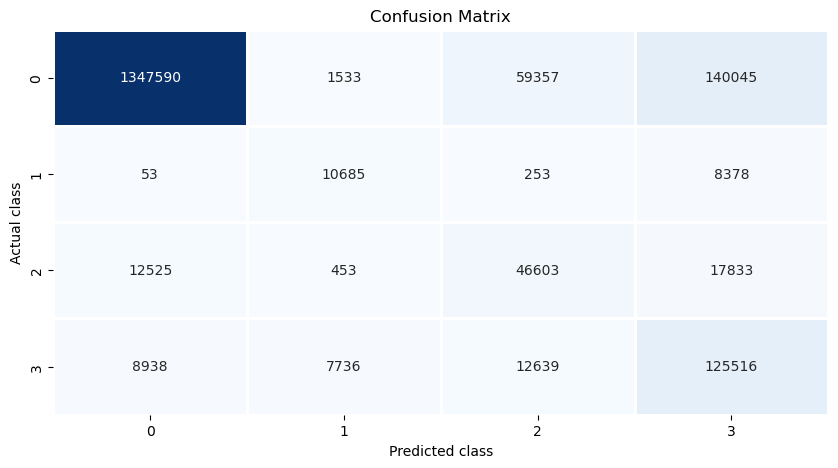

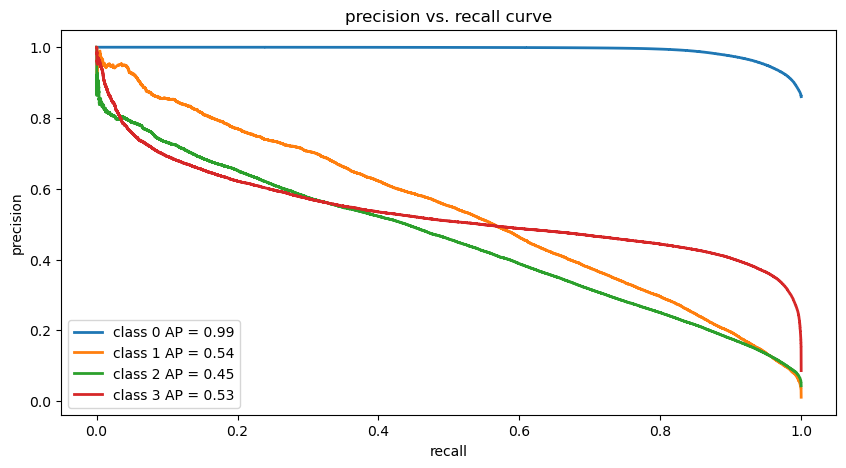

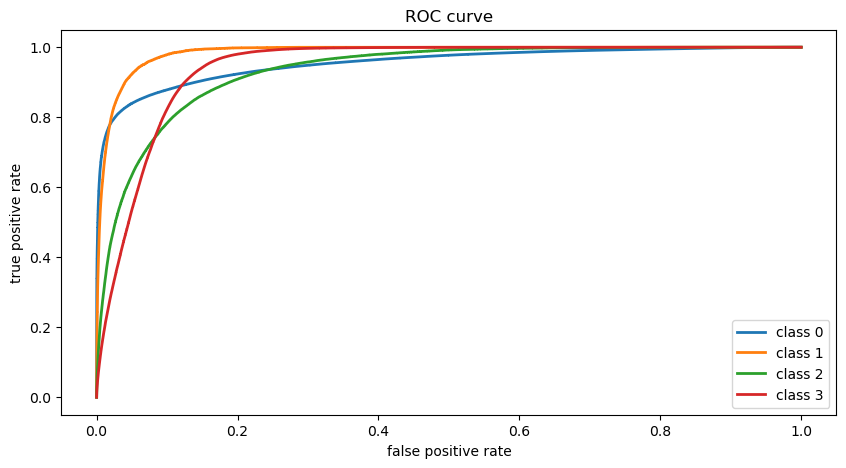

0 ROC AUC OvR: 0.9540
1 ROC AUC OvR: 0.9853
2 ROC AUC OvR: 0.9324
3 ROC AUC OvR: 0.9424
average ROC AUC OvR: 0.9535


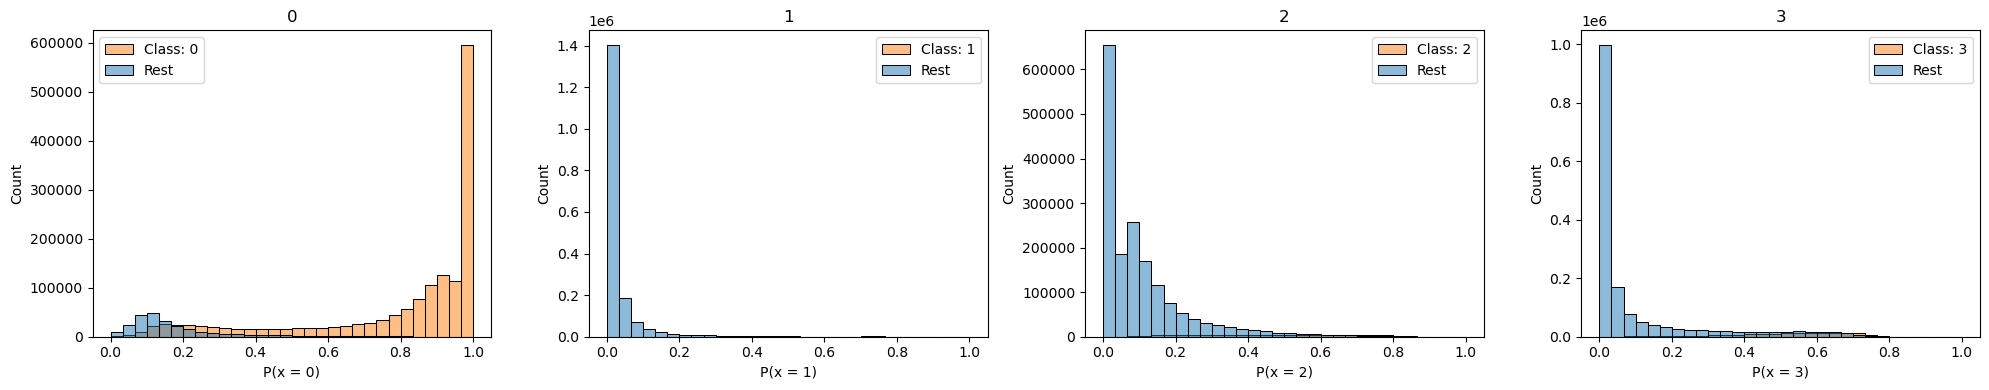

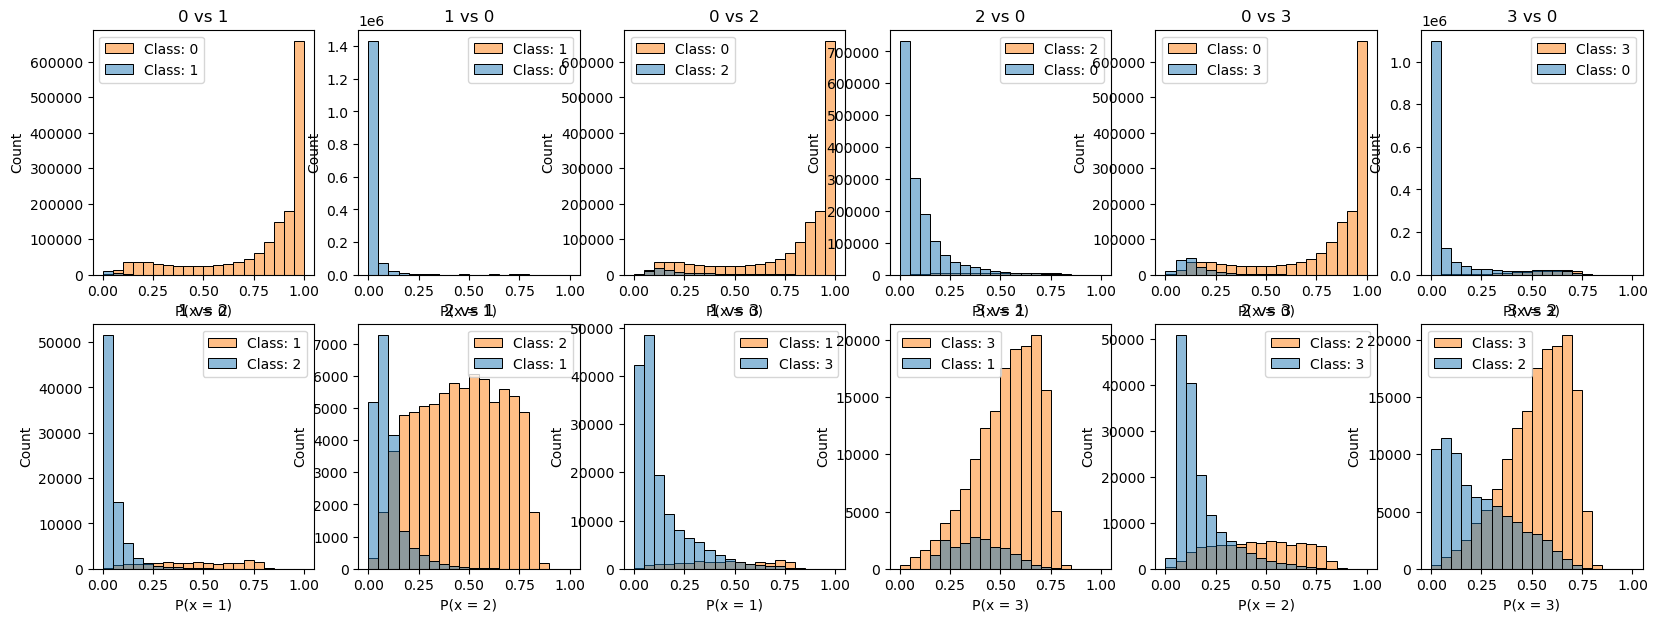

0 vs 1 ROC AUC OvO: 0.9934
1 vs 0 ROC AUC OvO: 0.9945
0 vs 2 ROC AUC OvO: 0.9274
2 vs 0 ROC AUC OvO: 0.9370
0 vs 3 ROC AUC OvO: 0.9623
3 vs 0 ROC AUC OvO: 0.9478
1 vs 2 ROC AUC OvO: 0.9746
2 vs 1 ROC AUC OvO: 0.9584
1 vs 3 ROC AUC OvO: 0.8986
3 vs 1 ROC AUC OvO: 0.7603
2 vs 3 ROC AUC OvO: 0.8830
3 vs 2 ROC AUC OvO: 0.8803
average ROC AUC OvO: 0.9265


In [7]:
# Mean probabilities for nn

y_probs_nn = {key: y_probs[key] for key in y_probs.keys() if key in ["mlp", "lstm", "conv_lstm", "transformer"]}

mean_nn_y_prob = np.divide(sum(y_probs_nn.values()), len(y_probs_nn.keys()))
mean_nn_y_pred = [np.argmax(i) for i in mean_nn_y_prob]


print("Mean models results:")
custom_multiclass_report(y_test, mean_nn_y_pred, mean_nn_y_prob)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95   1548525
           1       0.62      0.60      0.61     19369
           2       0.54      0.57      0.56     77414
           3       0.51      0.83      0.63    154829

    accuracy                           0.89   1800137
   macro avg       0.66      0.73      0.69   1800137
weighted avg       0.92      0.89      0.90   1800137



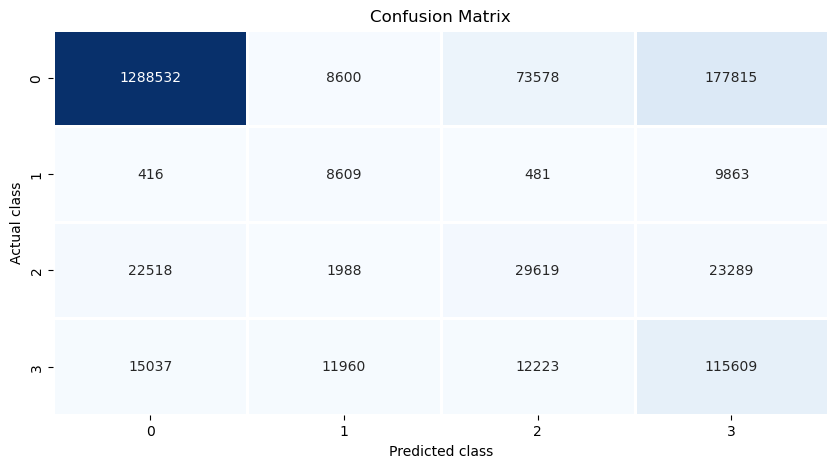

In [8]:
# Max prob predictions

# Predict on test set
y_prob_joint = np.concatenate([y_probs[x] for x in y_probs], 1)
y_pred_maxprob = [np.argmax(values) % 4 for values in y_prob_joint]
# -----------------------------------------------------
# Printing metrics
print(classification_report(y_test, y_pred_maxprob))
# -----------------------------------------------------
#  # Plot confusion matrix
plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    xticklabels=[0, 1, 2, 3],
    yticklabels=[0, 1, 2, 3],
    cbar=False,
    fmt="d",
    linewidths=1,
    cmap="Blues",
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.show()
# -----------------------------------------------------

              precision    recall  f1-score   support

           0       0.98      0.88      0.93   1548525
           1       0.47      0.65      0.54     19369
           2       0.41      0.62      0.49     77414
           3       0.44      0.78      0.56    154829

    accuracy                           0.85   1800137
   macro avg       0.58      0.73      0.63   1800137
weighted avg       0.91      0.85      0.87   1800137



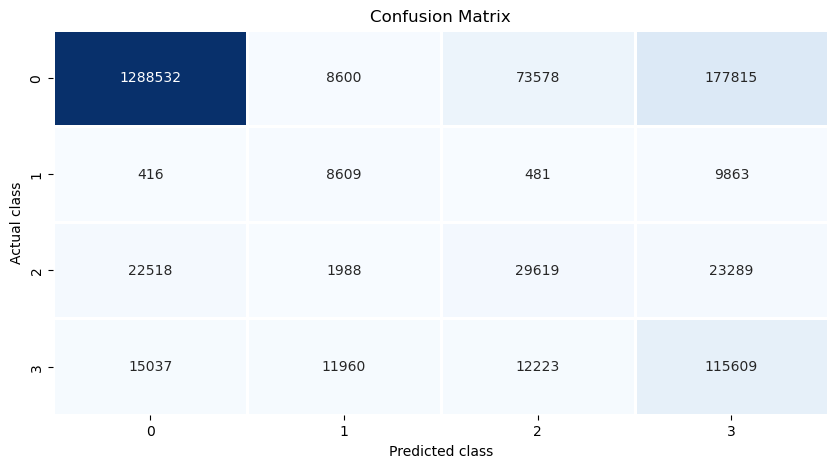

In [9]:
# Max prob predictions for nn

# Predict on test set
y_prob_joint = np.concatenate([y_probs_nn[x] for x in y_probs_nn], 1)
y_pred_maxprob = [np.argmax(values) % 4 for values in y_prob_joint]
# -----------------------------------------------------
# Printing metrics
print(classification_report(y_test, y_pred_maxprob))
# -----------------------------------------------------
#  # Plot confusion matrix
plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    xticklabels=[0, 1, 2, 3],
    yticklabels=[0, 1, 2, 3],
    cbar=False,
    fmt="d",
    linewidths=1,
    cmap="Blues",
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.show()
# -----------------------------------------------------